In [1]:
from tqdm.notebook import tqdm

In [44]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table
# import astropy.units as u

# Dlnpyutils
from dlnpyutils.utils import bspline,mad

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Astrologium():
    '''
    A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry.
    '''
    def __init__(self,teff,logg,abund,obsphot,distance,isochrones,ext_law='CCM89',rv=3.1):
        
        '''
        Inputs:
        ------
            teff:       2x1 array-like
                        Teff and error of star np.array([teff,teff_err])
                        
            logg:       2x1 array-like
                        Log(g) and error of star np.array([logg,logg_err])
                    
            abund:      2x1 array-like
                        first column is [M/H] and [Alpha/M] and the second column is the errors
                    
            obs_phot:   6x2 array-like
                        first column is BP, G, RP, J, H, and K and the second column is the errors
                        
            distance:   float
                        distance to star in pc
                    
            isochrones: astropy Table 
                        PARSEC isochrone table
                        
            ext_law:    string, optional
                        extinction law to use. Default is CCM89.
                        
                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022
                        
            rv:         float, optional
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
                        (required to be 3.1 if ext_law = 'F99')

        '''
        
        # Teff and log(g)
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.logg  = logg[0] # log(g)
        self.logg_err = logg[1] # log(g) error
        
        # Salaris [Fe/H] Asplund 2021 et al.
        self.salfeh = abund[0,0]+np.log10(0.659*(10**(abund[1,0]))+0.341) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.341/(0.659*(10**(abund[1,0]))+0.341))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # Absolute Magnitudes Not Derreddened
        self.absphot = self.phot-self.distmod
        
        # PARSEC isochrones
        self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        self.uniq_masses = np.unique(self.iso['Mass'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
        
        mass_idx = []
        for i in range(len(self.uniq_masses)):
            masses, = np.where(self.iso['Mass']==self.uniq_masses[i])
            mass_idx.append(np.array([min(masses),max(masses)]))
        
        self.mass_idx = np.asarray(mass_idx)
            
        # Effective Wavelengths of different passbands in units of microns
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K
        self.extlaw_coeff = self.extcoeff(ext_law) # alav
        
        # Solar values
        self.lgteff_sun = np.log10(5773.) # +/- 16 K Asplund et al. 2021
        self.logg_sun = 4.4374 # +/- 0.0005 Gray D.F., 1992 
        
        # Calculated values 
        self.ext = self.extinction()
        self.bcs = self.bolometric_corrections()
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value

        Inputs:
        ------
            data:  array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value

        Inputs:
        ------
            data:   array-like
                    data to search through

            value:  float or int
                    value of interest

        Output:
        ------
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    #############################################
    ### Extinction and Bolomteric Corrections ###
    #############################################
    
    def extcoeff(self,wavelength,rv=3.1,law='CCM89'):#,ref='G'):

        '''
        Calculate the relative extincion law coefficients for a given wavelength relative to the 
        BP, G, RP, J, H, K or user defined band

        Input:
        -----
            wavelength: float
                        Effective wavelength of band of interest in microns

            law:        str
                        extinction law to use

                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022

            rv:         float
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1

        Output:
        ------
            ext_coeff:  float
                        calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                        relative to the Gaia G band

        '''

        leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

        # select the extinction model
        if law == 'CCM89':
            ext_model = CCM89(Rv=rv)

        elif law == 'O94':
            ext_model = O94(Rv=rv)

        elif law == 'F99':
            ext_model = F99(Rv=rv)

        elif law == 'F04':
            ext_model = F04(Rv=rv)

        elif law == 'VCG04':
            ext_model = VCG04(Rv=rv)

        elif law == 'GCC09':
            ext_model = GCC09(Rv=rv)

        elif law == 'M14':
            ext_model = M14(Rv=rv)

        elif law == 'F19':
            ext_model = F19(Rv=rv)

        elif law == 'D22':
            ext_model = D22(Rv=rv)   

        # Calculate the relative extinction coefficient
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

        return ext_coeff_array
    
    def extinction(self):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and K bands
        
        Output:
        ------
            ext: 6x2 array
                 first column is the extinction values and the second is the errors
            
        '''
        
        # isochrone magnitude labels
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 200 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        # check to make sure teff of star is in range of the isochrone
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        # create "reddening" vector (slightly modified from the normal definition)
        red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1)
        red_vec[0] = -1*red_vec[0]
        
        ext_vec = self.extlaw_coeff/self.extlaw_coeff[1]
        
        # calculate the intrinsic colors using a b-spline
        bspline_vec = 999999.0*np.ones(5)
        bspline_vec_deriv = 999999.0*np.ones(5)
        
        for i in range(5):
            try:
                # Interpolate the color-Teff relation using a b-spline
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
                logTe = iso_['logTe']

                bspl = bspline(logTe,color)
                bspline_vec[i] = bspl(np.log10(self.teff))
                bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
            except:
                bspline_vec[i] = 999999.0
                bspline_vec_deriv[i] = 999999.0
                
        # calculate the extinctions and errors
        color_diff = obs_colors-bspline_vec
#         color_diff_err = obs_colors_err
        color_diff_err = np.sqrt(obs_colors_err**2+
                                 (np.multiply(bspline_vec,
                                              np.divide(bspline_vec_deriv*self.teff_err,self.teff)))**2)

        
        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        
        ext = 999999.0*np.ones((6,2))
        ext[:,0] = ext_vec*ag
        ext[:,1] = ext_vec*ag_err
        
        return ext
    
    def bolometric_corrections(self):
        '''
        Calculate the bolometric corrections for each band
        
        Return:
        ------
            bcs: 6x2 array
                 array of bolometric corrections and errors
        '''
        
        # pick isochrone points with temperatures within 200 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        # check to make sure teff of star is in range of the isochrone
        if np.size(np.squeeze(teffcut))==0:
            bcs = 999999.0*np.ones((6,2))
            self.bcs = bcs
            return bcs
        
        bcs = 999999.0*np.ones((6,2))
        for i in range(6):
            try:
                logTe = iso_['logTe']

                bspl = bspline(logTe,iso_['mbolmag']-iso_[self.labels[i]])
                bcs[i,0] = bspl(np.log10(self.teff))
                bcs[i,1] = np.abs(bspl.derivative()(np.log10(self.teff))*self.teff_err)
                
            except:
                bcs[i,0] = 999999.0
                bcs[i,1] = 999999.0
                
        return bcs
    
    ##############################################
    ### Magnitudes, Extinctions, Ages & Masses ###
    ##############################################
    
    def teff_2_appmags(self,teff,mass,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff:     float
                      Teff of star 
                      
            mass:     float
                      mass of star
        
        Output:
        ------
            calc_mag: 6x2 array 
                      expected intrinsic magnitude for the given temperature and mass
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        ext = self.ext[:,0]
        bcs = self.bcs[:,0]
        
        # Figure out if mass is actually in the ages given in the isochrone table
        if mass in self.uniq_masses:
            
            ### pick out a single isochrone 
            midx, = np.where(self.uniq_masses==mass)
            iso_ = self.iso[self.mass_idx[int(midx)][0]:self.mass_idx[int(midx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                phot_part = 4.74-bcs[i]+ext[i]+self.distmod
                spec_part = (5/2)*(np.log10(mass)+4*(lgteff-self.lgteff_sun)-(self.logg-self.logg_sun))
                calc_mags[i] = phot_part - spec_part
                
            return calc_mags
            
        else:
            mass_lo,mass_hi = self.neighbors(self.uniq_masses,mass)
            if verbose:
                print('[mass_lo,mass_hi]: ',[mass_lo,mass_hi])
            
            ### Pick out single isochrones
        
            # lighter
            midx_lo, = np.where(self.uniq_masses==mass_lo)
            iso_lo = self.iso[self.mass_idx[int(midx_lo)][0]:self.mass_idx[int(midx_lo)][1]]
            
            # heavier
            midx_hi, = np.where(self.uniq_masses==mass_hi)
            iso_hi = self.iso[self.mass_idx[int(midx_hi)][0]:self.mass_idx[int(midx_hi)][1]]
            
#             ### Temperature Check
#             if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
#             if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a b-spline to get the apparent mags
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                phot_part = 4.74-bcs[i]+ext[i]+self.distmod
                spec_part_lo = (5/2)*(np.log10(mass_lo)+4*(lgteff-self.lgteff_sun)-(self.logg-self.logg_sun))
                spec_part_hi = (5/2)*(np.log10(mass_hi)+4*(lgteff-self.lgteff_sun)-(self.logg-self.logg_sun))
                
                spec_part_interp = interp1d([mass_lo,mass_hi],[spec_part_lo,spec_part_hi],extrapolate=True)
                
                calc_mags[i] = phot_part - spec_part_interp(mass)

            return calc_mags
    
    def get_mass(self,guess_masses=np.linspace(0.,10.)[::20]):#,verbose=False):
        '''
        Find best fitting age for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_masses: array 
                          initial guesses for ages in Gyr

            
        Output:
        ------
            mass:         float 
                          best age according to chi^2 space search
                        
            chi:          float
                          best chi^2 according to chi^2 space search
                        
            rmse:         float
                          RMSE of the result
            
        '''
            
        # initialize lists
        
        curve_masses = []
        curve_masses_err = []
        curve_chis = []
        curve_rmses = []

        # loop over age and ak space 
        for i in range(len(guess_masses)): 
            try:
                # calculate best mass
                obs_quants = self.phot
                obs_quants_err = self.phot_err

                popt_mass,pcov_mass = curve_fit(self.teff_2_appmags,self.teff,obs_quants,p0=guess_masses[i],
                                                method='lm',sigma=obs_quants_err,absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_masses.append(float(popt_mass))
                curve_masses_err.append(np.sqrt(float(pcov_mass)))
                curve_mags = np.asarray(self.teff_2_appmags(self.teff,float(popt_mass)))

                curve_chis.append(sum((curve_mags-obs_quants)**2/obs_quants_err**2))
                curve_rmses.append(np.sqrt(sum((curve_mags-obs_quants)**2)/len(curve_mags)))

            except:
                # populate lists
                curve_masses.append(999999.0)
                curve_masses_err.append(999999.0)
                curve_chis.append(999999.0)
                curve_rmses.append(999999.0)
        
        # find smallest chisq value and corresponding mass
        idx = np.asarray(curve_chis).argmin()
        mass = np.asarray(curve_masses)[idx]
        mass_err = np.asarray(curve_masses_err)[idx]
        chi = np.asarray(curve_chis)[idx]
        rmse = np.asarray(curve_rmses)[idx]
        self.mass = mass
        self.mass_err = mass_err
        self.chi = chi
        self.rms = rmse

        return mass, mass_err, chi, rmse
    
    ##############
    ### Masses ###
    ##############
    
    def age_2_mass(self,age):
        '''
        Calculate the mass of a star from its age
        
        Input:
        -----
            age:      2x1 array
                      age of a star in Gyr and associated error

        Output:
        ------
            mass:     float 
                      mass of star in solar masses
            
            mass_err: float
                      error in the calculated mass of the star
        '''

        if self.age == 999999.0:
            return 999999.0
#             return np.array([999999.0,999999.0])
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            return 999999.0
#             return np.array([999999.0,999999.0])
        try:
            ### calculate the mass and error using interpolation
            bspl = bspline(iso_['logAge'],iso_['Mass'])
            mass = bspl(np.log10(age*10**9))
            
        except:
            mass = 999999.0

        if np.isfinite(mass)==False:
            return 999999.0
        
        return mass
    


In [ ]:
 ##############
    ### Masses ###
    ##############
    
    def mass_2_age(self,mass):
        '''
        Calculate the age given the mass of a star
        
        Input:
        -----
            mass: float
                  mass of star
        
        Return:
        ------
            age:  float
                  age of star
        '''
        
        spl = bspline(self.iso['Mass'],self.iso['logAge'],extrapolate=True)
        age = 10**spl(mass)
        self.age = age
        return age

In [3]:
leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757])

def ccm_a(x):
    '''
    a(x) function from CCM et al. 1989

    Input:
    -----
        x: float
           effective wavelength in units of 1/micron

    Output:
    ------
        a: float
           value of the "a" function from CCM et al. 89  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a

    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
             0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a

    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a

        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a

def ccm_b(x):
    '''
    b(x) function from ccm et al. 1989

    Input:
    -----
        x: float
           effective wavelength in units of 1/micron

    Output:
    ------
        b: float
           value of the "b" function from CCM et al. 89 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b

    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
             0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b

    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b

        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b

def ccm89(wave,rv=3.1):
    '''
    Calculate the relative extinction of one band to the V band using
    Cardelli et al. 1989 (A\lambda/Av)

    Inputs:
    ------
        wave: array like
              effective wavelength in units of micron

        rv:   float
              Rv Slope of the extinction law (= Av/E(B-V)). default is 3.1

    Output:
    ------
        alav: float
              extinction relative to Av (A\lambda/Av)
    '''
    x=1/wave
    
    if np.size(x)<=1:
        return ccm_a(x)+ccm_b(x)/rv
    
    alav = 999999.0*np.ones(len(x))
    for i in range(len(x)):
        alav[i] = ccm_a(x[i])+ccm_b(x[i])/rv
        
    return alav

from scipy.interpolate import interp1d

def f99(wave):
    '''
    Calculate the relative extinction to E(B-V) using Fitzpatrick 1999 extinction law
    assuming Rv (= Av/E(B-V)) is the standard 3.1 for the Milky Way

    Input:
    -----
        wave: float
              effective wavelength in units of microns

    Output:
    ------
        alav: float
              extinction relative to Av (A\lambda/Av)
    '''
    recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])
    alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])

    x=1/wave
    spl = interp1d(recip_anchors,alebv_anchors)
    alav = spl(x)/3.1
    return alav

def sfdebv_2_ext(ebv,wave):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010 and Fitzpatrick 1999
    
    Inputs:
    ------
        ebv:  float
              Schlegel E(B-V) value
              
        wave: float
              wavelength of band to calculate extinction in mircons
        
    Output:
    ------
        ext:  float
              extinction in the band with the effective wavelength of wave
    '''
    
    micron_ext = (0.78/1.32)*ebv # Schlafly et al. 2010
    ext = f99(wave)/f99(1)*micron_ext # Fitzpatrick 1999
    return ext

import astropy.units as u
def convert_sfdebv(wave,ebv,rv=3.1):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction in mircons
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    fitz = F99(Rv=rv)
    return fitz(1/(wave*u.micron))/fitz(1*u.micron)*micron_extinction

import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(ref*u.micron)
    
    return ext_coeff

### Geometry

import MagellanicStream as MagellanicStream

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

# PARSEC

In [4]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive = massive[np.argsort(massive['Mass'])]
massive = massive['MH','Mass','logAge','logTe','logg','G_BPEDR3mag','GEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag','mbolmag']

# I noticed that there's some weird points marked as RGB, so I cut those out with
cut = np.poly1d(np.polyfit([4600,5400],[0.5,2],1))
massive = massive[np.where(massive['logg']>cut(10**massive['logTe']))]

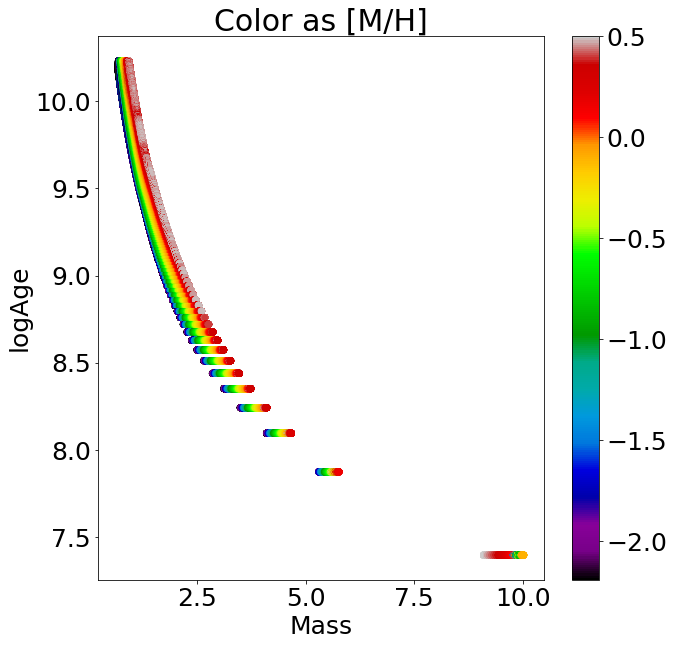

In [11]:
plt.figure(figsize=[10,10])
plt.scatter(massive['Mass'],massive['logAge'],c=massive['MH'],cmap='nipy_spectral')
plt.colorbar()
plt.title(r'Color as [M/H]')
plt.xlabel(r'Mass')
plt.ylabel(r'logAge')
plt.show()

NameError: name 'plt' is not defined

In [21]:
# def closest(data,value):
#     '''
#     Find nearest value in array to given value

#     Inputs:
#     ------
#         data:  array-like
#                data to search through

#         value: float or int
#                value of interest

#     Output:
#     ------
#         close: float or int
#                value in data closest to given value
#     '''

#     data = np.asarray(data)

#     return data[(np.abs(np.subtract(data,value))).argmin()]

In [20]:
# singfeh = massive[np.where(massive['MH']==closest(massive['MH'],-0.5))]

# plt.figure(figsize=[10,10])
# plt.scatter(singfeh['Mass'],singfeh['logAge'],c=singfeh['MH'],cmap='nipy_spectral')
# plt.colorbar()
# plt.title(r'Color as [M/H]')
# plt.xlabel(r'Mass')
# plt.ylabel(r'logAge')
# plt.show()

# APOGEE

In [5]:
lmcdr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17rev1_qacuts.fits.gz')

apoafe = lmcdr17['ALPHA_M']+lmcdr17['M_H']-lmcdr17['FE_H']
apoafe_err = np.sqrt(lmcdr17['ALPHA_M_ERR']**2+lmcdr17['M_H_ERR']**2+lmcdr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = lmcdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(lmcdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

from dlnpyutils import coords
from astropy.coordinates import SkyCoord

lmcx, lmcy, lmcdis = LMCdisk_cart(lmcdr17['RA'], lmcdr17['DEC'])
lmcr = elliptical_radius(lmcx,lmcy)

### lmcdr17
gc = SkyCoord(ra=lmcdr17['RA']*u.degree, dec=lmcdr17['DEC']*u.degree, frame='icrs')
lms_lmc,bms_lmc = coords.gal2mag(gc.galactic.l.value,gc.galactic.b.value)

for i in range(len(lms_lmc)):
    if lms_lmc[i] > 180.:
        lms_lmc[i] = lms_lmc[i]-360

# Gaia Mag Errors

In [6]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

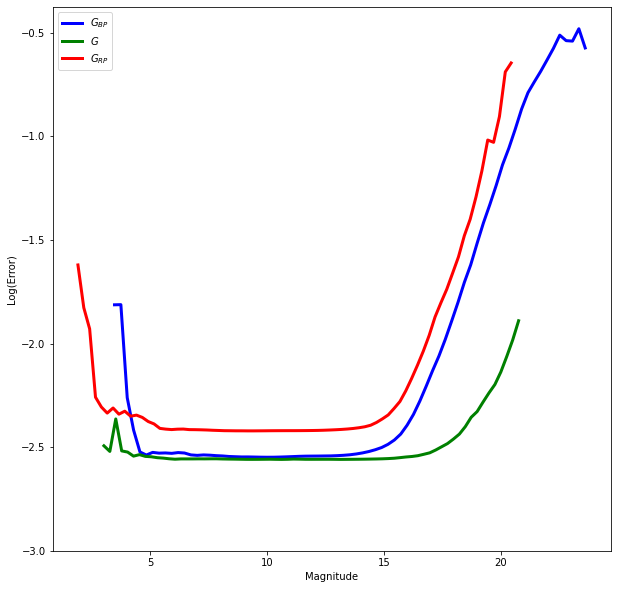

In [7]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

# Calculation

In [32]:
# lmc2_ext = 999999.0*np.ones((len(lmcdr17),6))
# lmc2_ext_err = 999999.0*np.ones((len(lmcdr17),6))
# lmc2_bcs = 999999.0*np.ones((len(lmcdr17),6))
# lmc2_mass = 999999.0*np.ones(len(lmcdr17))
# lmc2_mass_err = 999999.0*np.ones(len(lmcdr17))
# lmc2_chi = 999999.0*np.ones(len(lmcdr17))
# lmc2_rmse = 999999.0*np.ones(len(lmcdr17))
# lmc2_age = 999999.0*np.ones(len(lmcdr17))

# for i in tqdm(range(len(lmcdr17))):
    
#     # Initialize Aetas 
#     te = np.array([lmcdr17['TEFF'][i],lmcdr17['TEFF_ERR'][i]])
    
#     lg = np.array([lmcdr17['LOGG'][i],lmcdr17['LOGG_ERR'][i]])
    
#     ab = np.array([[lmcdr17['FE_H'][i],apoafe[i]],
#                    [lmcdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    
#     op = np.array([[lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
#                     lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
#                     lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
#                     lmcdr17['J'][i],lmcdr17['H'][i],lmcdr17['K'][i]],
#                    [bperr[i],gerr[i],rperr[i],lmcdr17['J_ERR'][i],
#                     lmcdr17['H_ERR'][i],lmcdr17['K_ERR'][i]]]).T
    
#     di = (1/lmcdr17['GAIAEDR3_PARALLAX'][i])*1000

#     CalcMass = Astrologium(te,lg,ab,op,di,massive)
    
#     exts = CalcMass.extinction()
#     lmc2_ext[i,:],lmc2_ext_err[i,:] = exts[:,0],exts[:,1]
#     CalcMass.bolometric_corrections()
#     lmc2_mass[i],lmc2_mass_err[i],lmc2_chi[i],lmc2_rmse[i] = CalcMass.get_mass()
#     lmc2_age[i] = CalcMass.mass_2_age(lmc2_mass[i])

In [33]:
# plt.hist(lmc2_mass,range=(0,10),bins=25)

In [34]:
# plt.figure(figsize=[12,7])
# plt.hist(lmc2_age,range=(0,20),bins=25,histtype='step',lw=3.0)
# plt.legend()
# plt.xlabel(r'Age')
# plt.ylabel(r'Number')
# # plt.savefig('mass_first_agehist_lmc.png',bbox_inches='tight')
# plt.show()

# Calculation

In [45]:
lmc_ext = 999999.0*np.ones((len(lmcdr17),6))
lmc_ext_err = 999999.0*np.ones((len(lmcdr17),6))
lmc_bcs = 999999.0*np.ones((len(lmcdr17),6))
lmc_mass = 999999.0*np.ones(len(lmcdr17))
lmc_mass_err = 999999.0*np.ones(len(lmcdr17))
lmc_chi = 999999.0*np.ones(len(lmcdr17))
lmc_rmse = 999999.0*np.ones(len(lmcdr17))

for i in tqdm(range(len(lmcdr17))):
    
    # Initialize Aetas 
    te = np.array([lmcdr17['TEFF'][i],lmcdr17['TEFF_ERR'][i]])
    
    lg = np.array([lmcdr17['LOGG'][i],lmcdr17['LOGG_ERR'][i]])
    
    ab = np.array([[lmcdr17['FE_H'][i],apoafe[i]],
                   [lmcdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    
    op = np.array([[lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    lmcdr17['J'][i],lmcdr17['H'][i],lmcdr17['K'][i]],
                   [bperr[i],gerr[i],rperr[i],lmcdr17['J_ERR'][i],
                    lmcdr17['H_ERR'][i],lmcdr17['K_ERR'][i]]]).T
    
    di = (1/lmcdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcMass = Astrologium(te,lg,ab,op,di,massive)
    
    exts = CalcMass.extinction()
    lmc_ext[i,:],lmc_ext_err[i,:] = exts[:,0],exts[:,1]
    CalcMass.bolometric_corrections()
    lmc_mass[i],lmc_mass_err[i],lmc_chi[i],lmc_rmse[i] = CalcMass.get_mass()

  0%|          | 0/6130 [00:00<?, ?it/s]

<ipython-input-44-65a841b9b3b7>:90: RuntimeWarning: invalid value encountered in log10
  self.distmod = 5.0*np.log10(distance)-5.0


In [3]:
CalcMass.bcs

NameError: name 'CalcMass' is not defined

In [ ]:
def mass_2_age(mass,salfeh,isochrones):
    

In [37]:
match_age = 999999.0*np.ones(len(lmcdr17))

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mass_2_age_PARSEC(mass,salfeh,teff,isochrones):
    '''
    Inputs:
    ------
        mass: star mass in Msun
        teff: teff
        salfeh: Salaris corrected [Fe/H]
        isochrones: table of PARSEC isochrones
    
    Output:
    ------
        age: age in Gyr
    '''
    
    feh_lo,feh_hi = neighbors(isochrones['MH'],salfeh)
    
    test = np.where((isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
#     pdb.set_trace()
    
    idx_lo = np.where((isochrones['MH']==feh_lo)&
                                 (isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
    idx_lo = np.where(isochrones['MH']==feh_lo)
    
    iso_lo = isochrones[idx_lo]
    
#     idx_hi = np.where((isochrones['MH']==feh_hi)&
#                                  (isochrones['logTe']<np.log10(teff+200.))&
#                                  (isochrones['logTe']>np.log10(teff-200.)))
    
    idx_hi = np.where(isochrones['MH']==feh_hi)
    
    iso_hi = isochrones[idx_hi]
    
# try:
    # lower [Fe/H]
    sidx_lo = np.argsort(iso_lo['Mass'])
    smass_lo = iso_lo['Mass'][sidx_lo]
    _,uidx_lo = np.unique(smass_lo,return_index=True)
    smass_lo = smass_lo[uidx_lo]
    sage_lo = 10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9

    spl_lo = interp1d(smass_lo,sage_lo)

    # higher [Fe/H]
    sidx_hi = np.argsort(iso_hi['Mass'])
    smass_hi = iso_hi['Mass'][sidx_hi]
    _,uidx_hi = np.unique(smass_hi,return_index=True)
    smass_hi = smass_hi[uidx_hi]
    sage_hi = 10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9

    spl_hi = interp1d(smass_hi,sage_hi)

    # final spline
    final_spl = interp1d([feh_lo,feh_hi],[spl_lo(mass),spl_hi(mass)])
    age = final_spl(salfeh)
    return age
#     except:
#         return 999999.0

for i in tqdm(range(len(lmcdr17))):
    match_age[i] = mass_2_age_PARSEC(lmc_mass[i],salfeh[i],lmcdr17['TEFF'][i],massive)

  0%|          | 0/6130 [00:00<?, ?it/s]

ValueError: A value in x_new is below the interpolation range.

(array([6.123e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 5.000e+00]),
 array([-3.28736018e+00,  9.14583374e+05,  1.82917004e+06,  2.74375670e+06,
         3.65834336e+06,  4.57293002e+06,  5.48751668e+06,  6.40210334e+06,
         7.31669000e+06,  8.23127666e+06,  9.14586333e+06]),
 <BarContainer object of 10 artists>)

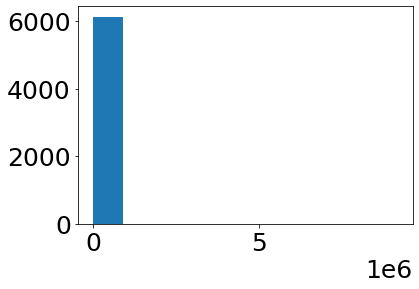

In [24]:
plt.hist(lmc2_mass)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


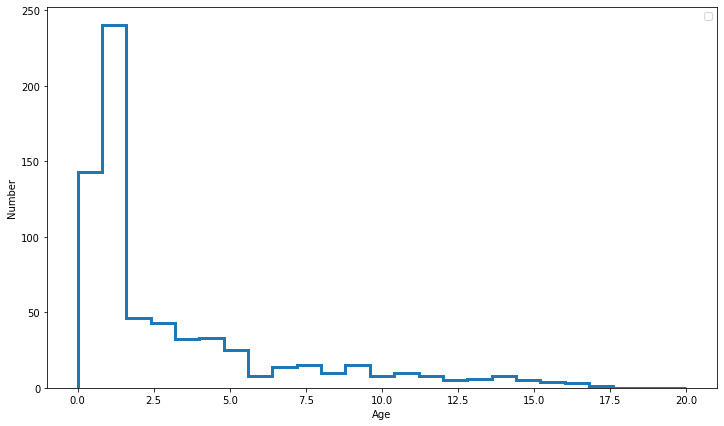

In [16]:
# plt.figure(figsize=[12,7])
# plt.hist(match_age,range=(0,20),bins=25,histtype='step',lw=3.0)
# plt.legend()
# plt.xlabel(r'Age')
# plt.ylabel(r'Number')
# plt.savefig('mass_first_agehist_lmc.png',bbox_inches='tight')
# plt.show()

(array([ 682.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 5447.]),
 array([2.61059956e-02, 3.99999851e+04, 7.99999440e+04, 1.19999903e+05,
        1.59999862e+05, 1.99999821e+05, 2.39999780e+05, 2.79999739e+05,
        3.19999698e+05, 3.59999657e+05, 3.99999616e+05, 4.39999575e+05,
        4.79999534e+05, 5.19999493e+05, 5.59999451e+05, 5.99999410e+05,
        6.39999369e+05, 6.79999328e+05, 7.19999287e+05, 7.59999246e+05,
        7.99999205e+05, 8.39999164e+05, 8.79999123e+05, 9.19999082e+05,
        9.59999041e+05, 9.99999000e+05]),
 [<matplotlib.patches.Polygon at 0x7f9e21683250>])

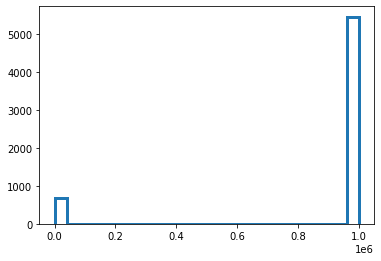

In [17]:
# plt.hist(match_age,bins=25,histtype='step',lw=3.0)